In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.feature_selection import RFECV 
import optuna
from sklearn.metrics import (roc_auc_score, classification_report, 
                           confusion_matrix, precision_recall_curve, 
                           average_precision_score, roc_curve)

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/nagah/workspace/creditas-case/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
df = pd.read_csv('../data/processed/clean-dataset.csv')
df.head()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,education_level
0,173460,52.0,5668.0,24000.0,5000.0,São Paulo,SP,900.0,0.0,0,...,2011.0,1.0,0.0,0.0,search,4028XXXX,/emprestimos/solicitar,PersonalLoan,female,Ensino Médio Completo
1,173455,20.0,5000.0,14200.0,5000.0,Guarulhos,SP,1500.0,0.0,0,...,2004.0,1.0,0.0,0.0,direct,7060XXXX,/emprestimos,Unknown,male,Ensino Médio Completo
2,173450,48.0,3000.0,17000.0,8000.0,Manaus,AM,1060.0,0.0,0,...,2010.0,1.0,0.0,0.0,affiliates,6906XXXX,/emprestimos/garantia-veiculo/solicitar,Unknown,male,Superior Completo
3,173442,56.0,7500.0,21000.0,12000.0,Maracás,BA,0.0,1.0,0,...,2012.0,1.0,0.0,0.0,social,4536XXXX,/emprestimos/solicitar,PersonalLoan,male,Unknown
4,173437,35.0,3379.0,16500.0,5000.0,Itaquaquecetuba,SP,0.0,0.0,0,...,2008.0,1.0,0.0,0.0,search,8588XXXX,/emprestimos/solicitar,PersonalLoan,male,Ensino Médio Completo


# Remoção de valores nulos

Aqui, opto pela remoção no lugar da imputação em razão do risco de data leakage.

In [4]:
initial_rows = len(df)
df.dropna(inplace=True)
final_rows = len(df)
print(f"Removendo valores nulos. {initial_rows - final_rows} linhas removidas ({((initial_rows - final_rows) / initial_rows):.2%} do dataset).")

Removendo valores nulos. 750 linhas removidas (5.00% do dataset).


# Feature Engineering

In [5]:
def feature_engineering(df):
    """Criação de novas features."""
    
    # Features de dívida
    debt_columns = ['dishonored_checks', 'expired_debts', 'banking_debts', 
                   'commercial_debts', 'protests', 'verified_restriction', 
                   'informed_restriction']
    
    df['total_debts'] = df[debt_columns].sum(axis=1)
    df['has_any_debt'] = (df['total_debts'] > 0).astype(int)
    df['multiple_debts'] = (df['total_debts'] > 1).astype(int)
    
    # Features financeiras
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['monthly_income'] + 1e-6)
    df['loan_to_value_ratio'] = df['loan_amount'] / (df['collateral_value'] + 1e-6)
    df['income_to_value_ratio'] = df['monthly_income'] / (df['collateral_value'] + 1e-6)
    
    # Features temporais
    df['car_age'] = 2017 - df['auto_year']  
    df['is_old_car'] = (df['car_age'] > 10).astype(int)
    
    # Features de comportamento
    df['high_loan_request'] = (df['loan_amount'] > df['loan_amount'].median()).astype(int)
    df['low_income_high_loan'] = ((df['loan_to_income_ratio'] > 2) & 
                                (df['monthly_income'] < df['monthly_income'].median())).astype(int)
    
    return df

In [6]:
df = feature_engineering(df)
print(f"Número de features após engineering: {len(df.columns)}")

Número de features após engineering: 39


# Pré-processamento

In [7]:
TARGET = 'sent_to_analysis'

# Features a serem excluídas 
excluded_features = [
    'id',  # Identificador único
    'pre_approved',  # Já filtramos por isso
    'zip_code',  # Muita cardinalidade
    'auto_model',  # Muita cardinalidade
    'landing_page',  # Variável operacional
    'landing_page_product'  # Variável operacional
]

In [8]:
y = df[TARGET]
X = df.drop(columns=[TARGET] + excluded_features)

In [9]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [10]:
print(f"Features numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Features categóricas ({len(categorical_features)}): {categorical_features}")

Features numéricas (25): ['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'verified_restriction', 'dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'monthly_payment', 'auto_year', 'form_completed', 'total_debts', 'has_any_debt', 'multiple_debts', 'loan_to_income_ratio', 'loan_to_value_ratio', 'income_to_value_ratio', 'car_age', 'is_old_car', 'high_loan_request', 'low_income_high_loan']
Features categóricas (7): ['city', 'state', 'informed_purpose', 'auto_brand', 'channel', 'gender', 'education_level']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [12]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print("\nTipos de dados após conversão:")
print(X_train.dtypes)


Tipos de dados após conversão:
age                       float64
monthly_income            float64
collateral_value          float64
loan_amount               float64
city                     category
state                    category
collateral_debt           float64
verified_restriction      float64
dishonored_checks           int64
expired_debts               int64
banking_debts               int64
commercial_debts            int64
protests                    int64
informed_restriction      float64
monthly_payment           float64
informed_purpose         category
auto_brand               category
auto_year                 float64
form_completed            float64
channel                  category
gender                   category
education_level          category
total_debts               float64
has_any_debt                int64
multiple_debts              int64
loan_to_income_ratio      float64
loan_to_value_ratio       float64
income_to_value_ratio     float64
car_age         

In [13]:
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Proporção target treino: {y_train.mean():.2%}")
print(f"Proporção target teste: {y_test.mean():.2%}")

Treino: 11398 amostras
Teste: 2850 amostras
Proporção target treino: 21.78%
Proporção target teste: 21.79%


In [14]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

In [15]:
categorical_transformer = Pipeline(
    steps=[("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Seleção de Features

In [17]:
rfe_estimator = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)
selector = RFECV(estimator=rfe_estimator, step=1, cv=StratifiedKFold(3), scoring='roc_auc', n_jobs=-1)

feature_selection_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('selector', selector)])
feature_selection_pipeline.fit(X_train, y_train)

selected_mask = feature_selection_pipeline.named_steps['selector'].get_support()
all_original_features = np.array(numeric_features + categorical_features)
selected_feature_names = all_original_features[selected_mask].tolist()
print(f"Número ótimo de features selecionado: {len(selected_feature_names)}")
removed_mask = ~selected_mask
removed_feature_names = all_original_features[removed_mask].tolist()
print("Features selecionadas:")
print(selected_feature_names)
print("\nFeatures removidas:")
print(removed_feature_names)

Número ótimo de features selecionado: 19
Features selecionadas:
['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'auto_year', 'form_completed', 'total_debts', 'loan_to_income_ratio', 'loan_to_value_ratio', 'income_to_value_ratio', 'city', 'state', 'informed_purpose', 'auto_brand', 'channel', 'gender', 'education_level']

Features removidas:
['verified_restriction', 'dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'has_any_debt', 'multiple_debts', 'car_age', 'is_old_car', 'high_loan_request', 'low_income_high_loan']


In [18]:
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

selected_numeric_features = [f for f in numeric_features if f in selected_feature_names]
selected_categorical_features = [f for f in categorical_features if f in selected_feature_names]

preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selected_numeric_features),
        ('cat', categorical_transformer, selected_categorical_features)
    ]
)


# Otimização

In [19]:
def objective(trial):
    pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

    param_grid = {
        "objective": "binary",
        "random_state": 42,
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [1.0, 10]),
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    lgbm = lgb.LGBMClassifier(**param_grid)
    pipeline = Pipeline(steps=[("preprocessor", preprocessor_selected), ("classifier", lgbm)])
    score = cross_val_score(
        pipeline, 
        X_train_selected, 
        y_train, 
        cv=5, 
        scoring="roc_auc", 
        n_jobs=-1
    )

    return score.mean()


In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600) 

print(f"Melhor score (ROC-AUC) na validação cruzada: {study.best_value:.4f}")
print("Melhores hiperparâmetros encontrados:")
print(study.best_params)

KeyboardInterrupt: 

# Treinamento

In [23]:
best_params = study.best_params

use_weight = best_params.pop('use_scale_pos_weight', False) 

final_lgbm_params = {
    'objective': 'binary',
    'random_state': 42,
    **best_params
}

if use_weight:
    pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    final_lgbm_params['scale_pos_weight'] = pos_weight

final_lgbm = lgb.LGBMClassifier(**final_lgbm_params)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('classifier', final_lgbm)
])

final_pipeline.fit(X_train_selected, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'collateral_value',
                                                   'loan_amount',
                                                   'collateral_debt',
                                                   'monthly_payment',
                                                   'auto_year',
                                                   'form_completed',
                                                   'total_debts',
                                                   'loan_to_income_ratio',
                                                   'loan_to_value_ratio',
                                                   'income_to_value_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('o...
                                                   'auto_brand', 'channel',
                                                   'gender',
                                                   'education_level'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5511669788927203,
                                learning_rate=0.028704795063264867,
                                max_depth=15, min_child_samples=93,
                                n_estimators=200, num_leaves=26,
                                objective='binary', random_state=42,
                                reg_alpha=0.002901554428894764,
                                reg_lambda=0.31368670121374115,
                                scale_pos_weight=10,
                                subsample=0.8111838798774171))])

# Avaliação

In [24]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)
    
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Average Precision (AP): {ap_score:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Matriz de Confusão')
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--'); axes[1].set_title('Curva ROC'); axes[1].legend()
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[2].plot(recall, precision, label=f'AP = {ap_score:.3f}')
    axes[2].set_title('Curva Precision-Recall'); axes[2].legend()
    
    plt.tight_layout(); plt.show()
    return auc_score, ap_score

AUC-ROC: 0.8237
Average Precision (AP): 0.5461

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.96      0.49      0.65      2229
         1.0       0.34      0.93      0.49       621

    accuracy                           0.58      2850
   macro avg       0.65      0.71      0.57      2850
weighted avg       0.83      0.58      0.61      2850



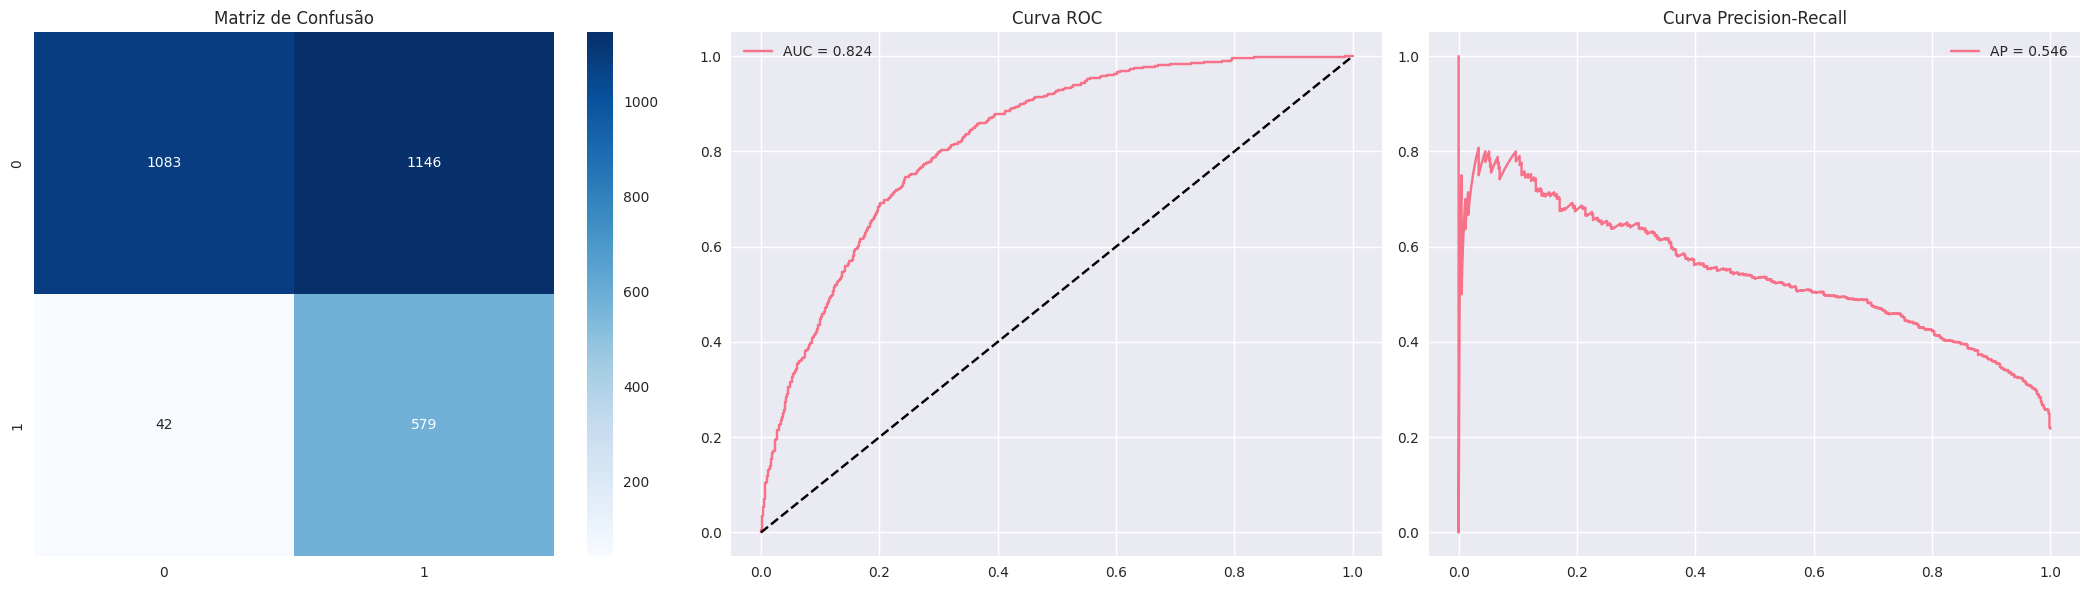

In [25]:
auc_score, ap_score = evaluate_model(final_pipeline, X_test, y_test)

# Fila de prioridades

In [26]:
def generate_priority_queue(model, X_data, original_data_indices):    
    probabilities = model.predict_proba(X_data)[:, 1]
    priority_df = pd.DataFrame({
        'client_id': original_data_indices, 
        'probability_score': probabilities
    })
    priority_df_sorted = priority_df.sort_values(
        by='probability_score', ascending=False
    ).reset_index(drop=True)
    
    return priority_df_sorted

In [27]:
priority_list = generate_priority_queue(final_pipeline, X_test, X_test.index)

print("Top 10 clientes para contato prioritário:")
print(priority_list.head(10))

Top 10 clientes para contato prioritário:
   client_id  probability_score
0       1933           0.950398
1       5740           0.949697
2       1367           0.949131
3       5624           0.948676
4      11242           0.948508
5       2564           0.948202
6      12179           0.947708
7       3854           0.947145
8       2704           0.944304
9      11741           0.943911


# Feature Importance

In [28]:
def display_feature_importance(pipeline, X_train_data):
    classifier = pipeline.named_steps['classifier']
    importances = classifier.feature_importances_
    feature_names = X_train_data.columns
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
        
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=importance_df.head(20), 
        x='importance', 
        y='feature',
        palette='viridis' 
    )
    plt.title('Top 20 Features Mais Importantes para o Modelo')
    plt.xlabel('Importância (Feature Importance)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return importance_df


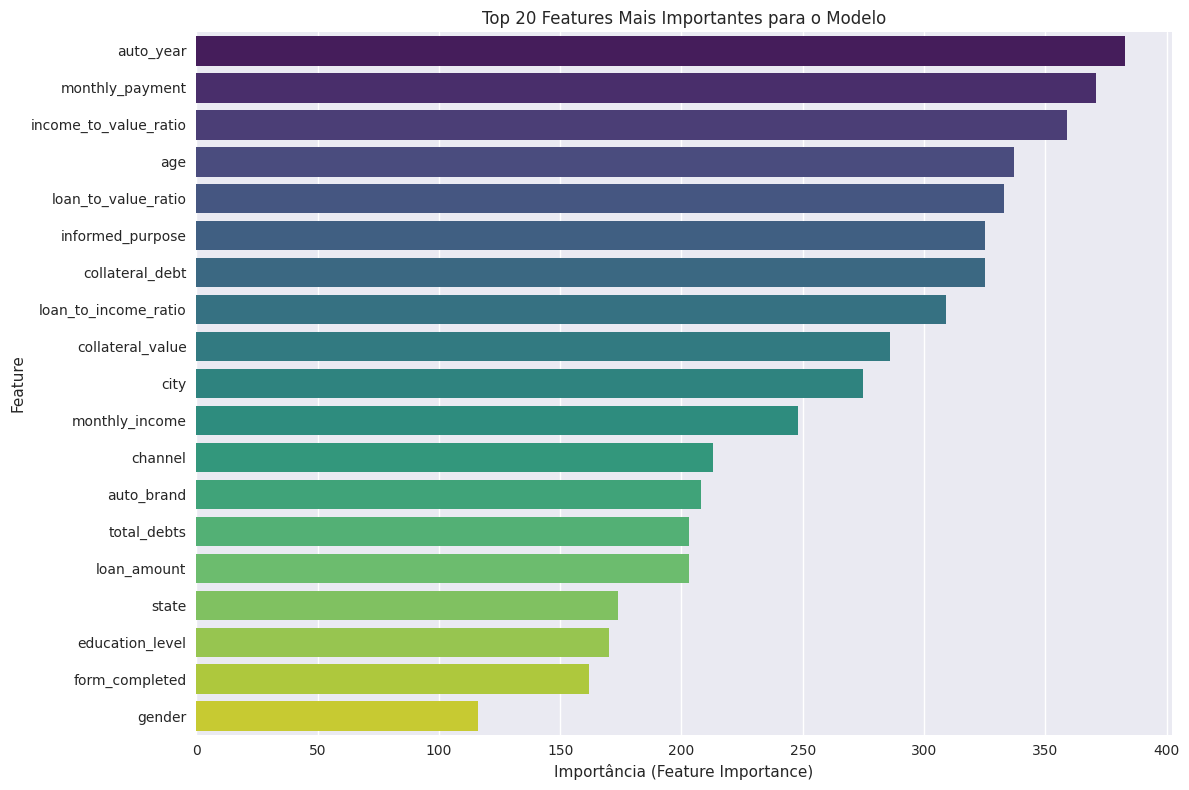

In [29]:
importance_df = display_feature_importance(final_pipeline, X_train_selected)

# Benchmark

In [30]:
def benchmark_comparison(model_auc, X_test, y_test):
    benchmarks = {'Modelo LGBM Otimizado': model_auc}
    benchmarks['Aleatório'] = 0.5
    benchmarks['Prioridade por Renda'] = roc_auc_score(y_test, X_test['monthly_income'])
    benchmarks['Prioridade por LTV'] = roc_auc_score(y_test, -X_test['loan_to_value_ratio'])
    
    benchmark_df = pd.DataFrame.from_dict(benchmarks, orient='index', columns=['AUC']).sort_values('AUC', ascending=False)
    print(benchmark_df)
    
    benchmark_df.plot(kind='bar', legend=False, title='Comparação de Performance (AUC)')
    plt.ylabel('Score AUC'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
    return benchmark_df


                            AUC
Modelo LGBM Otimizado  0.823720
Prioridade por Renda   0.638353
Aleatório              0.500000
Prioridade por LTV     0.398970


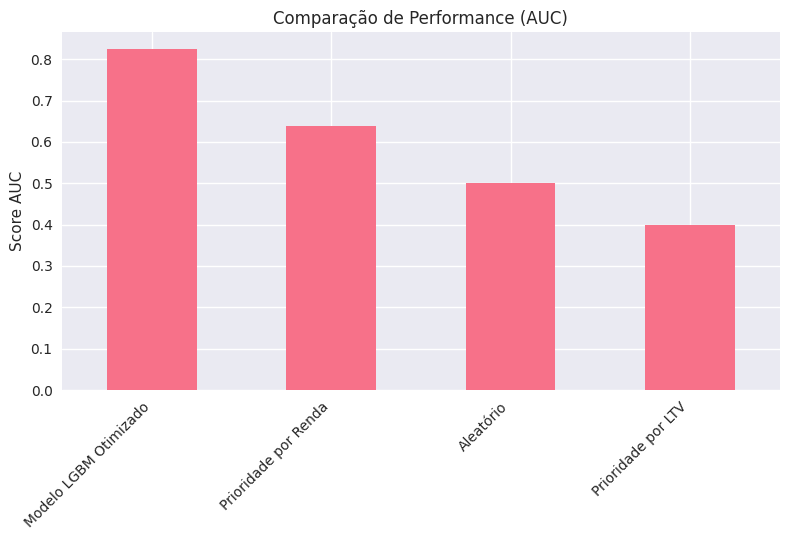

In [31]:
benchmark_df = benchmark_comparison(auc_score, X_test, y_test)

In [32]:
import pickle

filename = '../models/modelo_lightgbm.pkl'

with open(filename, 'wb') as file:
    pickle.dump(final_pipeline, file)

print(f"\nModelo salvo com sucesso no arquivo: {filename}")


Modelo salvo com sucesso no arquivo: ../models/modelo_lightgbm.pkl
